In [1]:
%load_ext autoreload
%autoreload 2

%aimport xclimate

In [2]:
from dataclasses import dataclass
from pathlib import Path
from typing import Hashable, Tuple

import numpy as np
import xarray as xr
import matplotlib as mpl
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import xclimate as xclim

In [3]:
@dataclass
class Variable:
    """Variable dataclass."""
    name: str
    long_name: str
    gcomp: str
    units: str
    derived: str | None

PATH_LE = Path("/glade/campaign/collections/gdex/data/d651056/CESM2-LE")

START_TMEAN = "1995-01"
END_TMEAN = "2014-12"
TIME_SLICE = slice(START_TMEAN,END_TMEAN)

VARIABLES = {
    "FSH": Variable("FSH", "sensible heat flux", "lnd", "W/m2", None),
    "ALBEDO": Variable("ALBEDO", "surface albedo", "lnd", "1", "(FLDS + FSDS) / (FIRE + FSR)"),
    "EFLX_LH_TOT": Variable("EFLX_LH_TOT", "total latent heat flux", "lnd", "W/m2", None),
    "FCEV": Variable("FCEV", "canopy evaporation", "lnd", "W/m2", None),
    "FCTR": Variable("FCTR", "canopy transpiration", "lnd", "W/m2", None),
    "FGEV": Variable("FGEV", "ground evaporation", "lnd", "W/m2", None),
    "TLAI": Variable("TLAI", "total leaf area index", "lnd", "m2/m2", None),
    "GPP": Variable("GPP", "gross primary productivity", "lnd", "gC/m2/s", None),
    "QOVER": Variable("QOVER", "surface runoff", "lnd", "mm/s", None),
    "QRUNOFF": Variable("QRUNOFF", "total runoff", "lnd", "mm/s", None),
    "VPD_CAN": Variable("VPD_CAN", "canopy vapor pressure deficit", "lnd", "Pa", None),
    "WIND": Variable("WIND", "wind speed", "lnd", "m/s", None),
    "CLDLOW": Variable("CLDLOW", "low cloud fraction", "atm", "1", None),
    "CLDTOT": Variable("CLDTOT", "total cloud fraction", "atm", "1", None),
    "PRECT": Variable("PRECT", "total precipitation", "atm", "m/s", None),
    "RAIN_FROM_ATM": Variable("RAIN_FROM_ATM", "rain from atmosphere", "lnd", "mm/s", None),
    "FLNT": Variable("FLNT", "net longwave flux at top of model", "atm", "W/m2", None),
    "FSNT": Variable("FSNT", "net shortwave flux at top of model", "atm", "W/m2", None),
    "uIVT": Variable("uIVT", "zonal integrated vapor transport", "atm", "kg/m/s", None),
    "vIVT": Variable("vIVT", "meridional integrated vapor transport", "atm", "kg/m/s", None),
}

print("Loading grids and gridcell area fields...")
A_FHIST = xr.open_dataset(
    "/glade/campaign/collections/cmip/CMIP6/timeseries-cmip6/" \
    "f.e21.FHIST_BGC.f19_f19_mg17.CMIP6-AMIP-2deg.001/atm/proc/tseries/month_1/" \
    "f.e21.FHIST_BGC.f19_f19_mg17.CMIP6-AMIP-2deg.001.cam.h0.AREA.200001-201412.nc",
    decode_timedelta=False)["AREA"].isel(time=0).fillna(0) / 1e6
A_FHIST.attrs["units"] = "km^2"
LND_GRID_FHIST = xclim.load_coupled_fhist_ppe("EFLX_LH_TOT", "lnd", "month_1")[["area", "landfrac"]].isel(member=0).fillna(0)
LND_GRID_FHIST = LND_GRID_FHIST.reindex_like(A_FHIST, method="nearest", tolerance=1e-3)
LA_FHIST = LND_GRID_FHIST.area * LND_GRID_FHIST.landfrac


A_LE = xclim.load_cesm2le("AREA", "atm", "month_1", "h0", keep_var_only=True)["AREA"].isel(member=0, time=0).fillna(0) / 1e6
A_LE.attrs["units"] = "km^2"
LND_GRID_LE = xclim.load_cesm2le("EFLX_LH_TOT", "lnd", "month_1", "h0")[["area", "landfrac"]].isel(member=0, time=0).fillna(0)
LND_GRID_LE = LND_GRID_LE.reindex_like(A_LE, method="nearest", tolerance=1e-3)
LA_LE = LND_GRID_LE.area * LND_GRID_LE.landfrac
print("Done loading grids and gridcell area fields.")

Loading grids and gridcell area fields...


/glade/u/home/bbuchovecky/miniforge3/envs/cpl_ppe_co2/lib/python3.12/site-packages/dask/array/core.py:4832: PerformanceWarning: Increasing number of chunks by factor of 10
  result = blockwise(
/glade/u/home/bbuchovecky/miniforge3/envs/cpl_ppe_co2/lib/python3.12/site-packages/dask/array/core.py:4832: PerformanceWarning: Increasing number of chunks by factor of 10
  result = blockwise(
/glade/u/home/bbuchovecky/miniforge3/envs/cpl_ppe_co2/lib/python3.12/site-packages/dask/array/core.py:4832: PerformanceWarning: Increasing number of chunks by factor of 10
  result = blockwise(
/glade/u/home/bbuchovecky/miniforge3/envs/cpl_ppe_co2/lib/python3.12/site-packages/dask/array/core.py:4832: PerformanceWarning: Increasing number of chunks by factor of 10
  result = blockwise(
/glade/u/home/bbuchovecky/miniforge3/envs/cpl_ppe_co2/lib/python3.12/site-packages/dask/array/core.py:4832: PerformanceWarning: Increasing number of chunks by factor of 10
  result = blockwise(
/glade/u/home/bbuchovecky/mini

Done loading grids and gridcell area fields.


In [13]:
fhist = {}

name = "EFLX_LH_TOT"
gcomp = "lnd"
units = "W/m2"
fhist[name] = xclim.load_coupled_fhist_ppe(name, gcomp, "month_1", "h0", keep_var_only=True, chunk=True)[name].reindex_like(A_FHIST, method="nearest", tolerance=1e-3)

name = "TLAI"
gcomp = "lnd"
units = "W/m2"
fhist[name] = xclim.load_coupled_fhist_ppe(name, gcomp, "month_1", "h0", keep_var_only=True, chunk=True)[name].reindex_like(A_FHIST, method="nearest", tolerance=1e-3)

In [14]:
le = {}

name = "EFLX_LH_TOT"
gcomp = "lnd"
units = "W/m2"
le[name] = xclim.load_cesm2le(name, gcomp, "month_1", "h0", keep_var_only=True, chunk={"time": -1}).sel(time=slice("1950-01", None))[name].reindex_like(A_LE, method="nearest", tolerance=1e-3)

name = "TLAI"
gcomp = "lnd"
units = "W/m2"
le[name] = xclim.load_cesm2le(name, gcomp, "month_1", "h0", keep_var_only=True, chunk={"time": -1}).sel(time=slice("1950-01", None))[name].reindex_like(A_LE, method="nearest", tolerance=1e-3)

In [ ]:
# fhist_loaded = {}
# fhist_loaded["LHFLX"] = fhist["LHFLX"].load()
# fhist_loaded["SHFLX"] = fhist["SHFLX"].load()

In [ ]:
# fhist_zm_loaded = {}
# fhist_zm_loaded["LHFLX"] = fhist_loaded["LHFLX"].where(LA_FHIST>0).mean(dim=["lon"]).load()
# fhist_zm_loaded["SHFLX"] = fhist_loaded["SHFLX"].where(LA_FHIST>0).mean(dim=["lon"]).load()

In [9]:
# le_loaded = {}
# le_loaded["LHFLX"] = le["LHFLX"].load()
# le_loaded["SHFLX"] = le["SHFLX"].load()

In [18]:
da1 = fhist["EFLX_LH_TOT"].weighted(LA_FHIST).mean(dim=["lat", "lon"]).groupby("time.year").mean().load()
da2 = le["EFLX_LH_TOT"].weighted(LA_LE).mean(dim=["lat", "lon"]).groupby("time.year").mean().load()

da1_violin = da1.sel(year=slice(1995, 2014)).mean(dim='year')
da2_violin = da2.sel(year=slice(1995, 2014)).mean(dim='year')

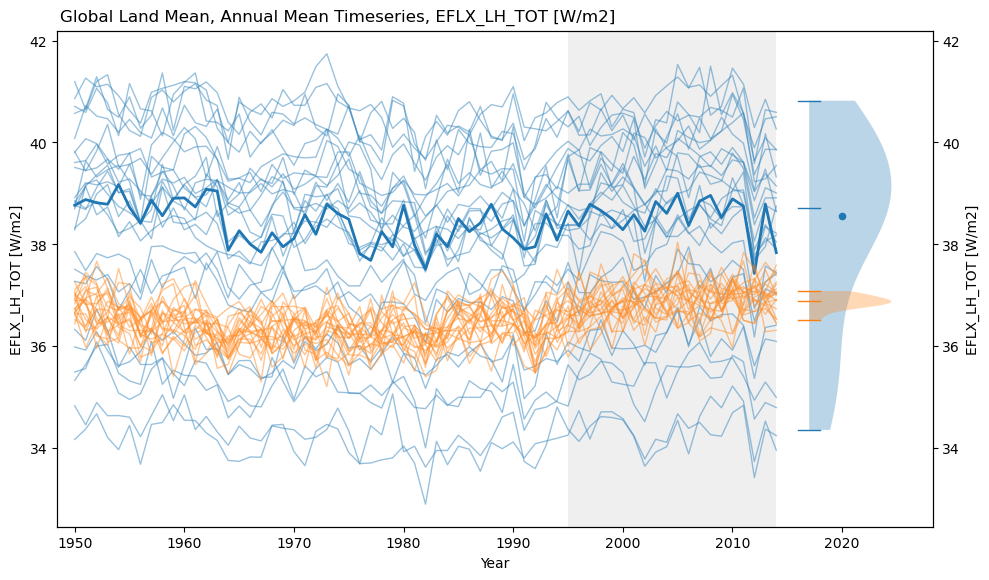

In [61]:
fig, ax = xclim.plot.plot_ensemble_line(
    das=[da1, da2],
    das_violin=[da1_violin, da2_violin],
    das_labels=["FHIST PPE", "CESM2 LE"],
    ylabel="EFLX_LH_TOT [W/m2]",
    plot_dim="year",
    xlabel="Year",
    highlight_member=[0, None],
    violin_xrange=(1995, 2014),
    violin_settings={"x": 2017},
    add_legend=False
)
fig.suptitle("Global Land Mean, Annual Mean Timeseries, EFLX_LH_TOT [W/m2]", x=0.065, y=0.96, ha="left")
plt.tight_layout()

In [44]:
da11 = fhist["EFLX_LH_TOT"].sel(time=slice("1995-01", "2014-12")).mean(dim=["time", "lon"]).load()
da12 = fhist["TLAI"].sel(time=slice("1995-01", "2014-12")).mean(dim=["time", "lon"]).load()

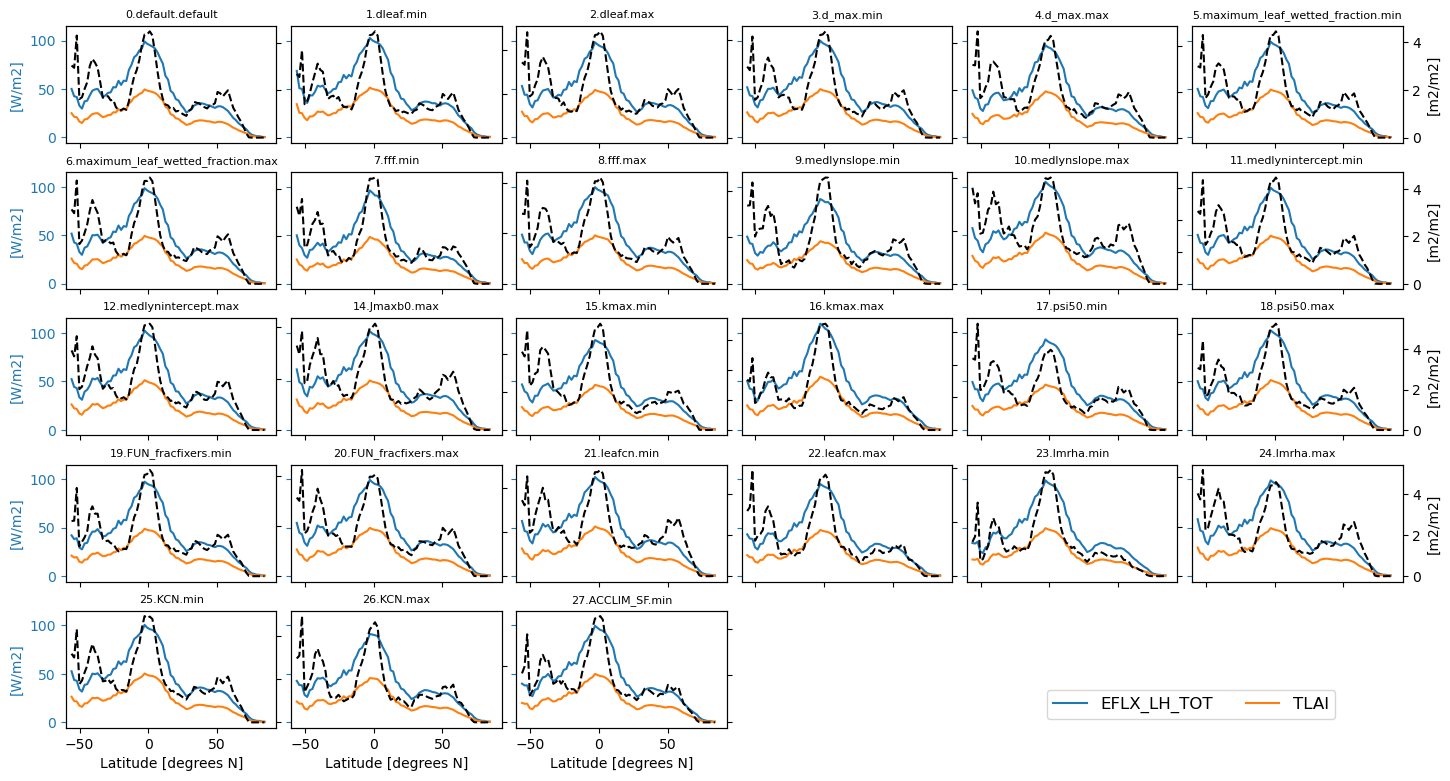

In [60]:
fig, axs = xclim.plot.plot_facetgrid_line(
    da=[da11, da11/2],
    da2=da12,
    labels=["EFLX_LH_TOT", "TLAI"],
    da2_kwargs={"ls": "--", "color": "k"},
    dim="member",
    x="lat",
    ylabel="[W/m2]",
    ylabel2="[m2/m2]",
    xlabel="Latitude [degrees N]",
    center_y=False,
    show_outer_labels=True,
)

for ax in axs.ravel():
    ax.set_xlim(-60, None)

In [42]:
xclim.plot.plot_facetgrid_line?

Signature:
xclim.plot.plot_facetgrid_line(
    da: 'xr.DataArray | List[xr.DataArray]',
    dim: 'str',
    x: 'Hashable',
    da_kwargs: 'dict | List[dict] | None' = None,
    da2: 'xr.DataArray | None' = None,
    da2_kwargs: 'dict | None' = None,
    center_y: 'bool' = False,
    ncol: 'int' = 6,
    figsize: 'Tuple' = (14, 8),
    show_outer_labels: 'bool' = False,
    xlabel: 'str | None' = None,
    ylabel: 'str | None' = None,
    ylabel2: 'str | None' = None,
    labels: 'List[str] | None' = None,
    hspace: 'float' = 0.25,
    parse_name: 'Callable' = <function get_member_name at 0x7fc3f80b1b20>,
)
Docstring:
Create faceted line plot panels for visualizing time series or other 1D data across multiple categories.

This function generates a grid of line plots (facets) based on a specified dimension,
with each panel showing the temporal or sequential evolution of a DataArray for one category.
Optionally supports dual y-axes to plot a second DataArray on the right y-axis, and can

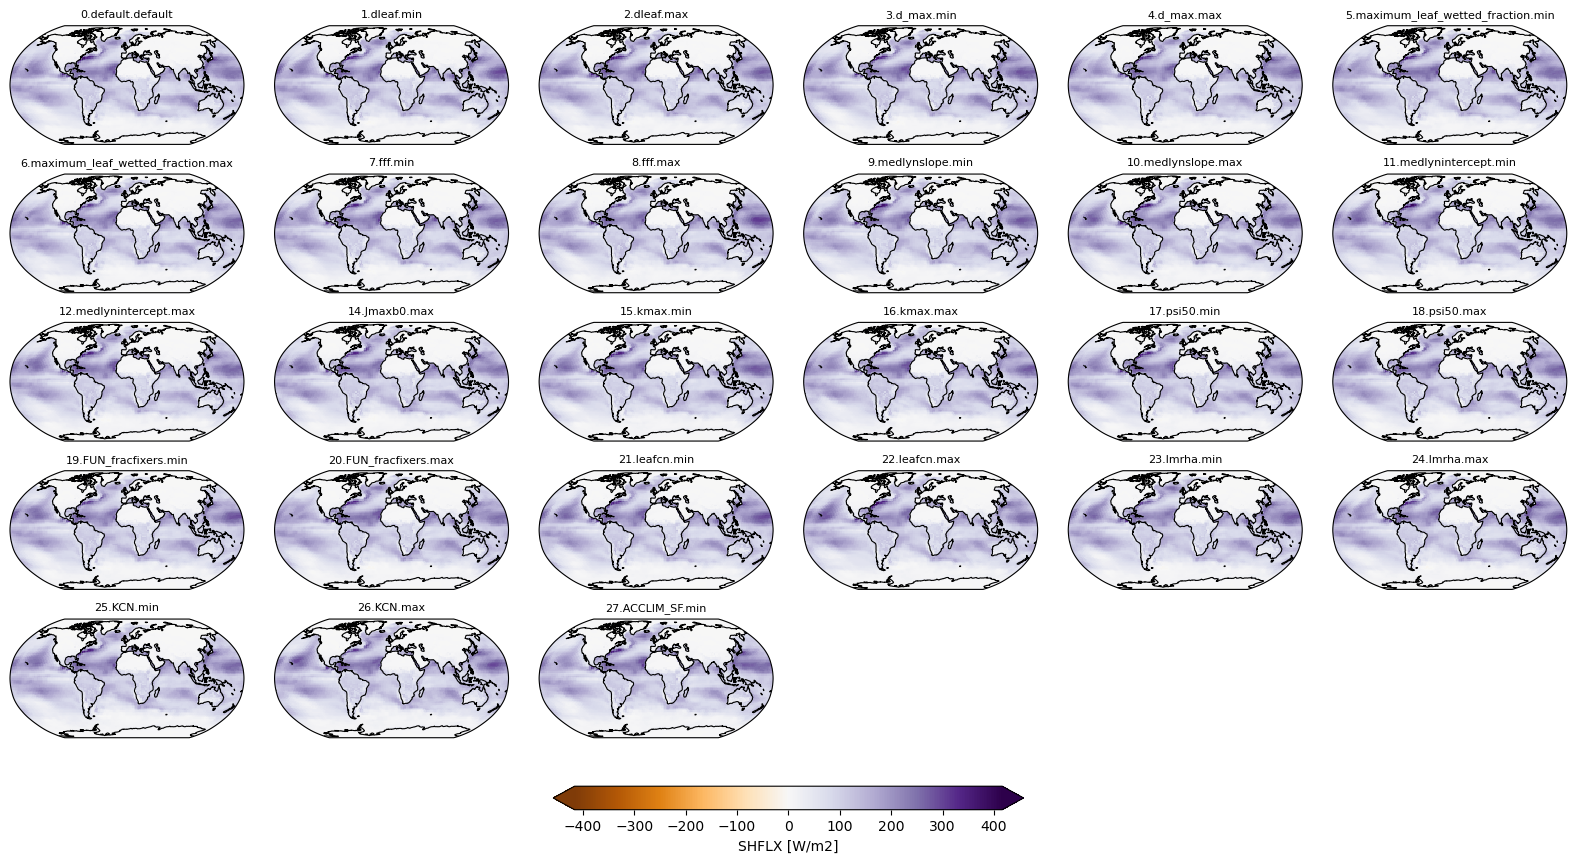

In [26]:
fig, axs =  xclim.plot.plot_facetgrid_map(
    da=fhist_loaded["LHFLX"],
    dim="member",
    label=f"{name} [{units}]",
    cmap="PuOr",
)

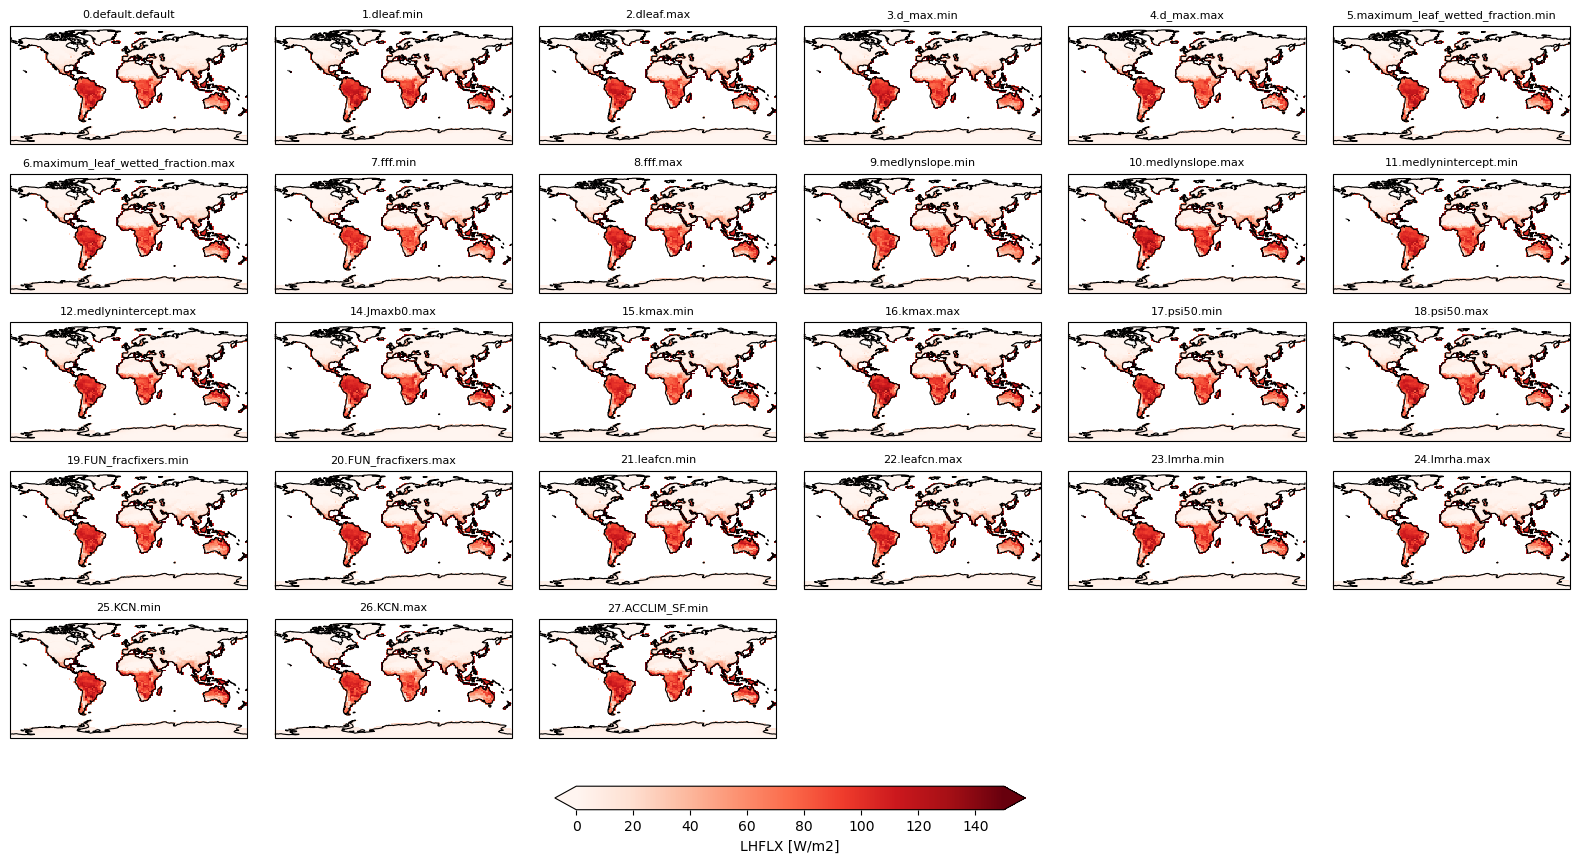

In [78]:
fig, axs = xclim.plot.plot_facetgrid_map(
    da=fhist_loaded["LHFLX"].where(LA_FHIST>0),
    dim="member",
    label="LHFLX [W/m2]",
    x="lon",
    y="lat",
    ncol=6,
    figsize=(16, 8),
    projection=ccrs.PlateCarree(),
    xlabel="Lon",
    ylabel="Lat",
    hspace=0.25,
    vmin=0,
    vmax=150,
    cmap="Reds",
)

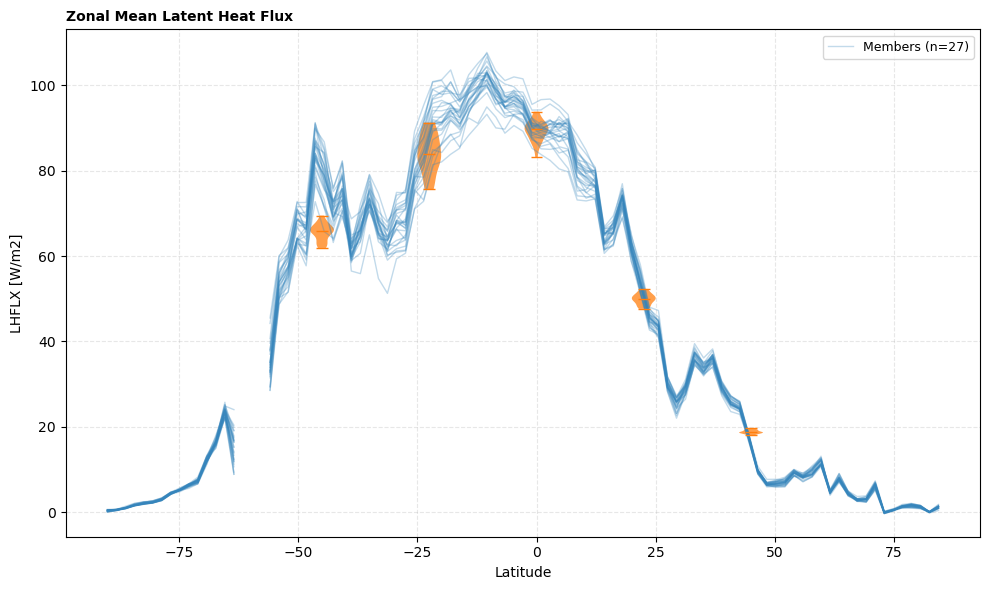

In [ ]:
fig, ax = xclim.plot.plot_zonal_violin(
    da_zm=fhist_zm_loaded["LHFLX"],
    member_coord='member',
    ylabel='LHFLX [W/m2]',
    title='Zonal Mean Latent Heat Flux',
    lat_bands=[(-60, -30), (-30, -15), (-15, 15), (15, 30), (30, 60)],
    vp_color="tab:orange",
)

(<Figure size 1000x600 with 2 Axes>,
 <Axes: xlabel='Latitude', ylabel='LHFLX [W/m2]'>)

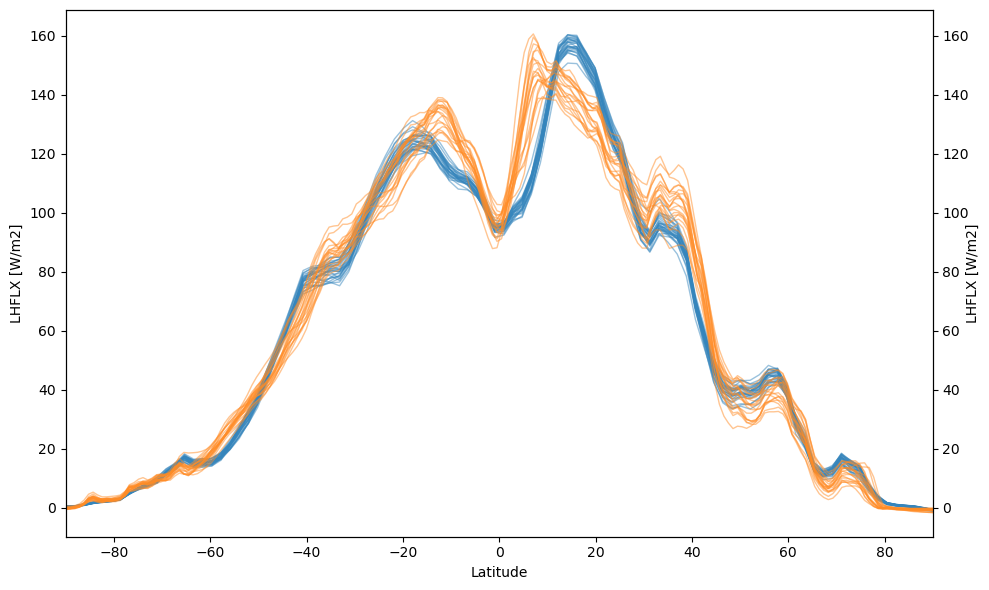

In [15]:
xclim.plot.plot_ensemble_zonal(
    das=[fhist_loaded["LHFLX"], le_loaded["LHFLX"]],
    das_labels=["FHIST PPE", "CESM2 LE"],
    ylabel="LHFLX [W/m2]",
)